# Определение перспективного тарифа для телеком компании
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Оглавление проекта
1. [Получение общей информации о данных.](#start)
2. [Предобработка данных.](#preprocess)
3. [Анализ данных.](#analys)
4. [Проверка гипотез.](#H)
5. [Общий вывод.](#result)

### Шаг 1. Получение общей информации о данных. <a id="start"></a>

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy.stats import levene
import math as mt
import warnings
warnings.filterwarnings('ignore')

Прочитаем исходные данные, выведем информацию и первые строки фреймов.

In [2]:
df_calls = pd.read_csv('calls.csv')
df_internet = pd.read_csv('internet.csv')
df_messages = pd.read_csv('messages.csv')
df_tariffs = pd.read_csv('tariffs.csv')
df_users = pd.read_csv('users.csv')

In [3]:
from IPython.display import display

# словарь, чтобы выводить ещё и имена датафреймов перед .info() и .head()
dataframes = {'calls':    df_calls,  
              'messages': df_messages, 
              'internet': df_internet, 
              'users':    df_users,
              'tariffs':  df_tariffs}

for df_name, df in dataframes.items():
    print('Dataframe: {} \n'.format(df_name))
    display(df.info())
    display(df.head())
    print('-----------------------------------------------\n\n')

Dataframe: calls 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


-----------------------------------------------


Dataframe: messages 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


-----------------------------------------------


Dataframe: internet 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


-----------------------------------------------


Dataframe: users 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


-----------------------------------------------


Dataframe: tariffs 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


-----------------------------------------------




### Вывод

С первого взгляда на данные видно, что в целом всё в достаточно хорошем виде. Нам понадобится привести даты к формату даты. В данным по использованному интернет-трафику есть столбец unnamed - скорее всего это дубликат индекса. По звонкам мы видим, что есть нулевые значения, нам предстоит понять как с ними поступить. В таблице по клиентам есть столбец churn_date с большим количеством Nan - нет данных по причине того, что клиент пользуется тарифом на момент выгрузки.

Данные мы будем анализировать по клиентам - как они пользуются тарифом по месяцам. Будем группировать таблицы и соединять их методом merge, чтобы в конце концов получить финальный фрейм, который и будем анализировать.

### Шаг 2. Предобработка данных. <a id="preprocess"></a>

Посмотрим сколько 0 в значениях duration (таблица df_calls).

In [4]:
(df_calls['duration']==0).sum()

39613

Получается, что около 19% звонков не приносят выручки оператору и являются неуспешными, пропущенными. С этими нулями сделать ничего нельзя.

Сразу приведем все даты (object) к нормальному формату даты:

In [5]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')

Добавим столбец с месяцами для дальнейшей группировки данных.

In [6]:
df_calls['month'] = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month

Создадим сгруппированные по user_id и month таблицы для звонков, сообщений и интернет-трафика.

In [7]:
calls_group = df_calls.groupby(['user_id','month']).agg({'duration':['sum','count']}).reset_index()
calls_group

user_id month duration      
                        sum count
0       1000     5   150.06    22
1       1000     6   158.90    43
2       1000     7   318.80    47
3       1000     8   389.87    52
4       1000     9   440.14    58
...      ...   ...      ...   ...
3169    1498    10   232.63    41
3170    1499     9    64.65     9
3171    1499    10   429.91    68
3172    1499    11   576.50    74
3173    1499    12   465.16    69

[3174 rows x 4 columns]

In [8]:
messages_group = df_messages.groupby(['user_id','month']).agg({'id':['count']}).reset_index()
messages_group

,user_id,month,id
,,,count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48


In [9]:
internet_group = df_internet.groupby(['user_id','month']).agg({'mb_used':['sum']}).reset_index()
internet_group

,user_id,month,mb_used
,,,sum
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51


Приступим к созданию общей таблицы для дальнейшей работы с ней.

In [10]:
df = pd.merge(calls_group[['user_id','month','duration']], messages_group, how='outer', on = ['user_id', 'month'])
df = pd.merge(df, internet_group, how='outer', on = ['user_id', 'month'])

Посмотрим, что получилось.

In [11]:
df.head()

user_id month duration          id   mb_used
                     sum count count       sum
0    1000     5   150.06  22.0  22.0   2253.49
1    1000     6   158.90  43.0  60.0  23233.77
2    1000     7   318.80  47.0  75.0  14003.64
3    1000     8   389.87  52.0  81.0  14055.93
4    1000     9   440.14  58.0  57.0  14568.91

Добавим название тарифа и город пользователя и возраст.

In [12]:
df['age'] = df['user_id'].map(df_users.set_index('user_id')['age'])
df['tariff_name'] = df['user_id'].map(df_users.set_index('user_id')['tariff'])
df['city'] = df['user_id'].map(df_users.set_index('user_id')['city'])

Переименуем все столбцы.

In [13]:
df.columns = ['user_id', 'month', 'duration', 'calls', 'messages', 'mb_used', 'age', 'tariff_name', 'city']

Добавляем к фрейму данные по тарифам.

In [14]:
df = pd.merge(df, df_tariffs, on='tariff_name')

In [15]:
df.head()

,user_id,month,duration,calls,messages,mb_used,age,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,150.06,22.0,22.0,2253.49,52,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,158.90,43.0,60.0,23233.77,52,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,318.80,47.0,75.0,14003.64,52,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,389.87,52.0,81.0,14055.93,52,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,440.14,58.0,57.0,14568.91,52,ultra,Краснодар,1000,30720,3000,1950,150,1,1


Добавим столбцы для измерения выручки.

Сделаем столбец gb_used - переведем потраченные мегобайты в гигобайты и так как мы работаем на жадного оператора округлим это значение вверх.

In [16]:
df['gb_used'] = (df['mb_used'] / 1024).apply(np.ceil)

Теперь сделаем столбцы с перерасходом gb_over, minutes_over, messages_over и сразу сделаем значения в рублях (если значения в разнице межу истраченным и включенным в тариф получилось отрицательная, значит перерасхода не было - заполним нулем).

In [17]:
df['gb_over'] = (df['gb_used'] - (df['mb_per_month_included'] / 1024)) * df['rub_per_gb']
df.loc[df['gb_over']<0, 'gb_over']=0

In [18]:
df['minutes_over'] = (df['duration'].apply(np.ceil) - df['minutes_included']) * df['rub_per_minute']
df.loc[df['minutes_over']<0, 'minutes_over']=0

In [19]:
df['messages_over'] = (df['messages'] - df['messages_included']) * df['rub_per_message']
df.loc[df['messages_over']<0, 'messages_over']=0

Посчитаем выручку за месяц по каждому клиенту.

In [20]:
df['revenue'] = df.loc[:,'gb_over':'messages_over'].sum(axis=1) + df['rub_monthly_fee']

In [21]:
df.head()

,user_id,month,duration,calls,messages,mb_used,age,tariff_name,city,messages_included,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used,gb_over,minutes_over,messages_over,revenue
0,1000,5,150.06,22.0,22.0,2253.49,52,ultra,Краснодар,1000,...,3000,1950,150,1,1,3.0,0.0,0.0,0.0,1950.0
1,1000,6,158.90,43.0,60.0,23233.77,52,ultra,Краснодар,1000,...,3000,1950,150,1,1,23.0,0.0,0.0,0.0,1950.0
2,1000,7,318.80,47.0,75.0,14003.64,52,ultra,Краснодар,1000,...,3000,1950,150,1,1,14.0,0.0,0.0,0.0,1950.0
3,1000,8,389.87,52.0,81.0,14055.93,52,ultra,Краснодар,1000,...,3000,1950,150,1,1,14.0,0.0,0.0,0.0,1950.0
4,1000,9,440.14,58.0,57.0,14568.91,52,ultra,Краснодар,1000,...,3000,1950,150,1,1,15.0,0.0,0.0,0.0,1950.0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   duration               3174 non-null   float64
 3   calls                  3174 non-null   float64
 4   messages               2717 non-null   float64
 5   mb_used                3203 non-null   float64
 6   age                    3214 non-null   int64  
 7   tariff_name            3214 non-null   object 
 8   city                   3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  mb_per_month_included  3214 non-null   int64  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

### Вывод

Мы сделали финальный фрейм для дальнейшего анализа. Всё, что возможно мы округлили в большую сторону и сделали расчет по перерасходу минут разговора, отправленных сообщений, интернет-трафика и посчитали итоговую выручку за месяц по каждому клиенту.

### Шаг 3. Анализ данных <a id="analys"></a>

Сделаем два среза данных по тарифам smart и ultra.

In [23]:
df_smart = df.query('tariff_name == "smart"')
df_ultra = df.query('tariff_name == "ultra"')

In [24]:
print('Количество строк в срезе smart', df_smart['user_id'].count())
print('Количество строк в срезе ultra', df_ultra['user_id'].count())
print('Доля клиентов тарифа smart', df_smart['user_id'].count() / df['user_id'].count())
print('Доля клиентов тарифа ultra', df_ultra['user_id'].count() / df['user_id'].count())

Количество строк в срезе smart 2229
Количество строк в срезе ultra 985
Доля клиентов тарифа smart 0.693528313627878
Доля клиентов тарифа ultra 0.30647168637212197


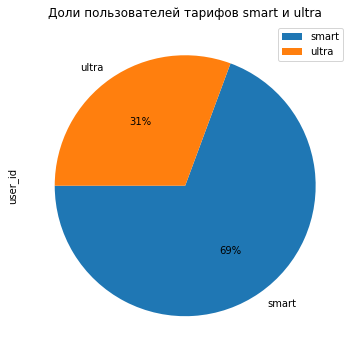

In [25]:
df.pivot_table(index='tariff_name', values='user_id', aggfunc='count').plot(kind='pie', figsize=(6,6), subplots=True, autopct='%.0f%%', startangle=180)
plt.title('Доли пользователей тарифов smart и ultra')
plt.show()

Если наша выборка является репрезентативной и соответствуют генеральной совокупности, то тарифом smart пользуются больше клиентов чем ultra, ~70% на 30%.

Выделим колонки с интересующими нас параметрами.

In [26]:
cols = ['duration', 'messages','mb_used']

<b/>Напишем функцию для построения попарных гистограмм для двух срезов по значения продолжительности вызовов, отправленным сообщениям и использованного интернет-трафика.<b/>

In [27]:
def hists(df1, df2):
    for i in cols:
        df1[i].plot(kind='hist', bins=50, alpha=0.8,figsize=(12,5), grid=True)
        df2[i].plot(kind='hist', bins=50, alpha=0.8,figsize=(12,5), grid=True)
        plt.title('Гистограмма значений {}'.format(i))
        plt.legend(['smart','ultra'])
        plt.xlabel(i)
        plt.show()

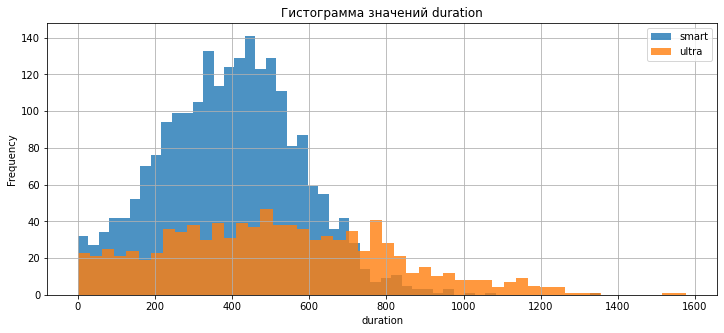

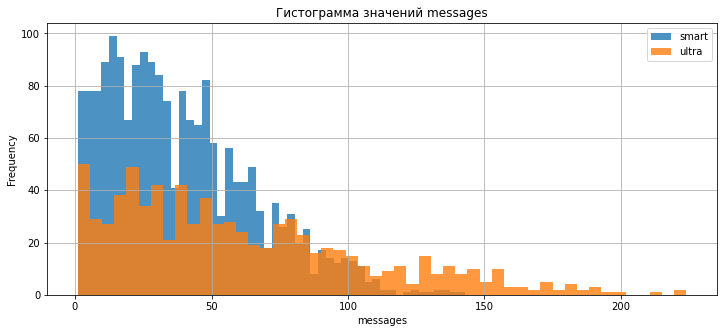

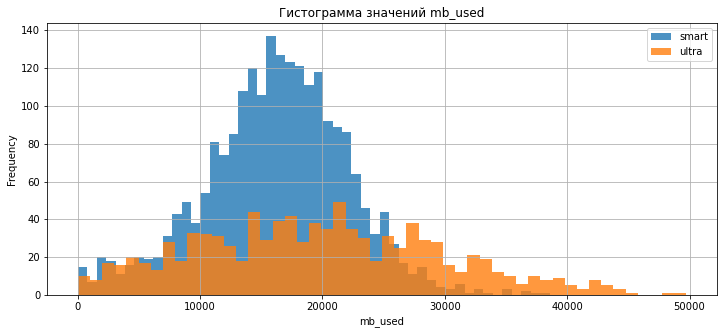

In [28]:
hists(df_smart, df_ultra)

In [29]:
df_smart[cols].describe()

,duration,messages,mb_used
count,2223.000000,1922.000000,2228.000000
mean,395.491606,38.716441,16215.661849
std,179.032472,26.787949,5861.736234
min,0.000000,1.000000,0.000000
25%,268.305000,17.000000,12649.272500
50%,398.790000,34.000000,16507.740000
75%,515.360000,55.000000,20043.792500
max,1354.220000,143.000000,38552.450000


In [30]:
df_ultra[cols].describe()

,duration,messages,mb_used
count,951.000000,795.000000,975.000000
mean,514.839327,61.161006,19668.485262
std,289.832022,45.931026,9943.050284
min,0.000000,1.000000,0.000000
25%,291.730000,24.000000,12008.305000
50%,497.890000,51.000000,19394.290000
75%,714.630000,87.500000,26896.550000
max,1578.060000,224.000000,49745.690000


Принимая во внимание, что в срезе тарифа smart наблюдений больше, рассмотрим полученные графики.

<b/>Длительность звонков:</b>

По гистограмме для тарифа smart видно, что есть ярко выраженный пик чуть меньше, чем на 500 минутах, гистограмма скошена влево. Это говорит о том, что пользователи тарифа smart хотят уложиться во включенный лимит, чтобы не платить за перерасход. Но есть и большое количество пользователей, кто превышает бесплатный лимит. Среднее значение - 395 минут.

По тарифу ultra гистограмма распределена ровнее, у пользователей большой лимит включенных минут и они спокойно разговаривают столько сколько им надо. Но в тоже время никто из пользователей не перерасходует свой лимит. Среднее значение - 514 минут, это как раз указывает на то, почему клиент решил не пользоваться тарифом smart. Каких-то 14 минут и пользователь готов выкладывать за тариф почти в 4 раза больше.

<b/>Сообщения:</b>

Гистограммы для сообщений выглядят похоже, пишут смс не очень часто - среднее 38 сообщений, но значительная часть пользователей тарифа smart не влезают в свой лимит в 50 сообщений - это и хорошо, пусть платят по 3 рубля за превышение. Ну а в ultra пользователи не могут выйти за установленные лимиты и среднее чуть выше чем для установленного лимита тарифа smart - 61 сообщение.

<b/>Интернет-трафик:</b>

Гистограмма похожа на нормальное распределение - всё почти симметрично расположено вокруг среднего значения. 

В среднем пользователи тарифа smart тратят 16,2 ГБ в месяц, значит в среднем каждый пользователь доплачивает за трафик, это хорошо влияет на выручку компании Мегалайн.

По тарифу ultra пользователи тратят в среднем по 19,6 ГБ, но тут уже есть пользователи, которые не влезают в установленный лимит 30 ГБ - интернета много не бывает.







Сделаем таблицу со средним, дисперсией и стандартным отклонением.

In [31]:
data = {'df_smart_duration':[df_smart['duration'].mean(), 
                             np.var(df_smart['duration'], ddof=1),
                             np.std(df_smart['duration'], ddof=1)],
       'df_ultra_duration':[df_ultra['duration'].mean(), 
                            np.var(df_ultra['duration'], ddof=1),
                            np.std(df_ultra['duration'], ddof=1)],
       'df_smart_messages':[df_smart['messages'].mean(), 
                            np.var(df_smart['messages'], ddof=1),
                            np.std(df_smart['messages'], ddof=1)],
       'df_ultra_messages':[df_ultra['messages'].mean(), 
                            np.var(df_ultra['messages'], ddof=1),
                            np.std(df_ultra['messages'], ddof=1)],
       'df_smart_mb_used':[df_smart['gb_used'].mean(), 
                           np.var(df_smart['gb_used'], ddof=1),
                           np.std(df_smart['gb_used'], ddof=1)],
       'df_ultra_mb_used':[df_ultra['gb_used'].mean(), 
                           np.var(df_ultra['gb_used'], ddof=1),
                           np.std(df_ultra['gb_used'], ddof=1)]}

In [32]:
df2 = pd.DataFrame(data)
df2.index = [['mean', 'var','std']]
df2

,df_smart_duration,df_ultra_duration,df_smart_messages,df_ultra_messages,df_smart_mb_used,df_ultra_mb_used
mean,395.491606,514.839327,38.716441,61.161006,16.336176,19.694359
var,32052.625911,84002.601260,717.594201,2109.659183,32.923756,94.146734
std,179.032472,289.832022,26.787949,45.931026,5.737923,9.702924


Дисперсия и стандартное отклонение по всем значениям выше по пользователям тарифа ultra. Это говорит о бОльшем разбросе данных пользователей этого тарифа. Из поведение более "расслабленное", так как, пользуясь тарифным планом ultra, они могут почти не задумываться о перерасходах - и собственно у них особо и не получается перерасходовать включенные в тариф услуги.

<b/>Кто наш клиент?</b>

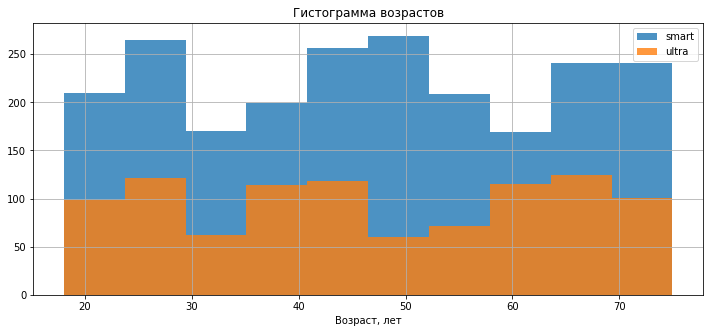

In [33]:
df_smart['age'].hist(figsize=(12,5), alpha=0.8)
df_ultra['age'].hist(figsize=(12,5), alpha=0.8)
plt.title('Гистограмма возрастов')
plt.legend(['smart','ultra'])
plt.xlabel('Возраст, лет')
plt.show()

Распределение возрастов клиентов без ярких скачков, все распределено весьма равномерно и схоже для пользователей смарт и ультра.

<b/>Теперь посмотрим на выручку от пользователей разных тарифов</b>

Посмотрим на суммы выручек по тарифам.

In [34]:
print(df_smart['revenue'].sum())
print(df_ultra['revenue'].sum())

2803165.0
2039100.0


In [35]:
df_smart['revenue'].describe().to_frame()

,revenue
count,2229.000000
mean,1257.588605
std,800.915599
min,550.000000
25%,550.000000
50%,962.000000
75%,1733.000000
max,6614.000000


In [36]:
df_ultra['revenue'].describe().to_frame()

,revenue
count,985.000000
mean,2070.152284
std,376.187114
min,1950.000000
25%,1950.000000
50%,1950.000000
75%,1950.000000
max,4800.000000


In [37]:
print('Количество "невлезающих" в тариф smart:', df_smart.query('revenue > 550')['user_id'].count())
print('Количество "невлезающих" в тариф ultra:', df_ultra.query('revenue > 1950')['user_id'].count())
print('Доля "невлезающих" в тариф smart:', df_smart.query('revenue > 550')['user_id'].count() / df_smart['user_id'].count())
print('Доля "невлезающих" в тариф ultra:', df_ultra.query('revenue > 1950')['user_id'].count() / df_ultra['user_id'].count())

Количество "невлезающих" в тариф smart: 1630
Количество "невлезающих" в тариф ultra: 134
Доля "невлезающих" в тариф smart: 0.7312696276357111
Доля "невлезающих" в тариф ultra: 0.13604060913705585


Почти 3/4 случаев пользователям smart приходится докупать услуги сверх плана, по тарифу ultra только 13,6% пользователей доплачивают сверх плана.

Теперь надо понять в каком интервале лежат основные величины выручки и вероятность попадания очень больших значений. (Правило трех сигм в данном случае не работает, потому будем смотреть через quantile со значениями 0.05 и 0.95.)

Нижнюю границу нет смысла считать, так как меньше стоимости тарифа мы заплатить не можем и вероятность наступления такого события равна нулю, но зато мы можем посмотреть большие значения и понять какая выручка маловероятна (0,1%).

In [38]:
threshold_smart = df_smart['revenue'].quantile(0.95)
threshold_ultra = df_ultra['revenue'].quantile(0.95)
df_smart_revenue = df_smart.query('revenue < @threshold_smart')
df_ultra_revenue = df_ultra.query('revenue < @threshold_ultra')

In [39]:
df_smart_revenue['revenue'].describe().to_frame()

,revenue
count,2117.000000
mean,1143.076523
std,624.036189
min,550.000000
25%,550.000000
50%,950.000000
75%,1550.000000
max,2810.000000


In [40]:
df_ultra_revenue['revenue'].describe().to_frame()

,revenue
count,932.00000
mean,1990.55794
std,147.47029
min,1950.00000
25%,1950.00000
50%,1950.00000
75%,1950.00000
max,2850.00000


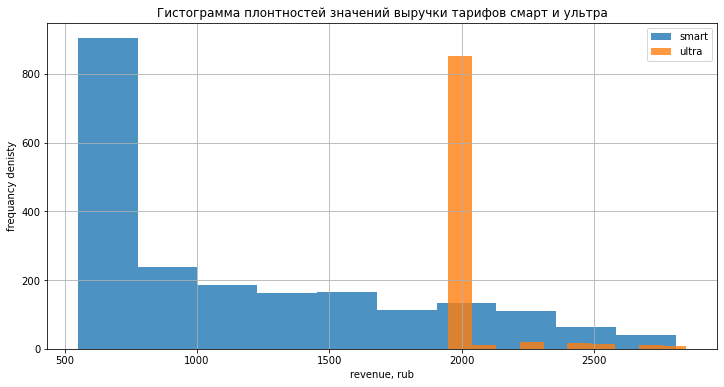

In [41]:
df_smart_revenue['revenue'].hist(figsize=(12,6), alpha=0.8)
df_ultra_revenue['revenue'].hist(figsize=(12,6), alpha=0.8)
plt.title('Гистограмма плонтностей значений выручки тарифов смарт и ультра')
plt.xlabel('revenue, rub')
plt.ylabel('frequancy denisty')
plt.legend(['smart','ultra'])
plt.show()

По гистограмме видно насколько больше объем пользователей смарта и видно, что у Ультра средние значения по выручке намного выше.

Мы убрали значения тех выручек, вероятность получения которых стремиться к нулю.

Средняя выручка по тарифу смарт - 1143 руб./мес. с пользователя
Средняя выручка по тарифу ультра - 1990 руб./мес. с пользователя

Около 70% пользователей тарифа смарт не влезают в свой план и доплачивают за услуги, в связи с чем средняя выручка от пользователя smart более чем в два раза выше чем стоимость тарифа.

Пользователи тарифа ультра редко не укладываются в свой тарифный план и среднее значение выручки - 1990 руб./мес. с пользователя.

### Вывод

Мы разобрали поведение пользователей двух тарифов. Смартовцам не хватает услуг, входящий в тариф, а Ультравцам бывает не хватает интернет, но звонки и смс им не удается израсходовать полностью. 

Возраст наших клиентов распределн равномерно от молодых до взрослых. 

3/4 пользователей тарифа смарт доплачивают за сверхлимит смс/звонков и трафика, в тоже время только 13% пользователей Ультра требуется доплата сверх лимита.



### Шаг 4. Проверка гипотез <a id="H"></a>

Сформулируем и проверим гипотезу.

Нулевая гипотеза: Средняя выручка пользователей тарифов «Смарт» и «Ультра» равны.

Альтернативная гипотеза: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Создадим два массива данных по выручке - для тарифа смарт и для тарифа ультра.

In [42]:
sample1 = df_smart['revenue']
sample2 = df_ultra['revenue']

Для проведения т-теста нам надо понимать отличаются ли дисперсии в этих выборках. Для проверки проведем тест Левена. Пороговым значения будем считать 5% - если p меньше этого значения, то дисперсии значимо отличаются друг от друга.

In [43]:
stat, p = levene(sample1, sample2)
p

8.052127898886171e-114

В данном случае получилось очень маленькое число, почти 0, что дает нам право считать, что у дисперсий этих выборок есть значимые различия. Значит в т-тесте мы будем указывать дополнительный параметр - equal_var=False.

In [44]:
alpha = .05
results = st.ttest_ind(sample1, sample2, equal_var=False)
print('p уровень значимости:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, выручка одинаковая')

p уровень значимости: 6.179723168444486e-274
Отвергаем нулевую гипотезу


Сформулируем и проверим следующую гипотезу.

Нулевая гипотеза: средняя выручка пользователей из Москвы равна выручки пользователей из других регионов.

Альтернативная гипотеза: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [45]:
print('Доля москвичей', df.query('city == "Москва"')['user_id'].count() / df['user_id'].count())
print('Доля других', df.query('city != "Москва"')['user_id'].count() / df['user_id'].count())

Доля москвичей 0.19010578718108276
Доля других 0.8098942128189173


Для понимания, что передавать в параметр equal_var в т-тесте также проведем тест Левена. Порогом будем считать 5%.

In [46]:
sample3 = df.query('city == "Москва"')['revenue']
sample4 = df.query('city != "Москва"')['revenue']

In [47]:
stats, p = levene(sample3, sample4)
p

0.02701982274883088

Хммм.... Здесь уже цифра не так близка к нулю, но все же меньше нашего установленного значения в 5%, то есть в т-тест опять передаем значение equal_var=False.

In [48]:
alpha = .05
results = st.ttest_ind(sample3, sample4, equal_var=False)
print('p уровень значимости:', results.pvalue)
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p уровень значимости: 0.46532858228722906
Не получилось отвергнуть нулевую гипотезу


### Вывод

Гипотезу о равенстве среднемесячных выручек по пользователям тарифа Смарт и Ультра мы отвергаем. При проведении t-теста p-уровень значимости стремиться к нулю, что не дает возможности утверждать что выручки от соответствующих пользователей равны.
Как мы выяснили ранее - средняя выручка за месяц по пользователю тарифа Ультра выше чем у пользователя тарифа Смарт. Но в целом объем пользователей тарифа Смарт выше, а это значит что в сумме эти пользователи приносят больше денег компании Мегалайн.

В нашей выборке около 80% пользователей не из столицы.
Тот же тест мы произвели и для пользователей из Москвы и дргуих городов.
Нулевую гипотезу о равенстве средних выручек для пользователей в разных городах нам отвергнуть не удалось. Это значит, что поведение пользователей обоих тарифов в Москве и других городах примерно одинаковое.

### Шаг 5. Общий вывод <a id="result"></a>

#### Исходные данные
В нашем распоряжении были данные о 500 пользователях компании Мегалайн – кто они, откуда,
каким тарифом пользуются, сколько звонков и сообщений каждый отправил в 2018 году. С
первого взгляда на данные, мы увидели, что они хорошо выгружены, но в отдельные таблицы.
Для анализа данных нам предстоит «склеить» таблицы, предварительно обработав неточности в
выгрузке.

#### Предобработка данных
Первым, что бросилось в глаза - 39613 нулевых значения параметра duration, что составляло более
19% от таблицы звонков клиента. Так как мы работаем на Мегалайн, тут принято округлять
значения в большую сторону даже если клиент проговорил какие-то доли секунд. Мы заменили
все нули на одну минуту разговора.

Далее мы привели значения в колонках с датами во всех таблицах к нормальному формату и
сделали отдельный столбец с месяцем звонка/смс/интернет сессии. После этого мы
сгруппировали таблицы по user_id и month и «склеили» их методом merge. После добавили из
таблицы users к общему фрейму значения названия тарифа и города, в котором проживает
пользователь.

Мы добавили новые столбцы для расчета итоговой выручки за месяц по каждому клиенту. Для
начала перевели мегабайты в гигабайты и округлили их вверх. После сделали колонки с
перерасходом звонков/ смс/интернет-трафика в рублях и сделали итоговой параметр revenue с
указанием общего дохода.

#### Анализ данных
Предварительно сделав два среза данных отдельно по тарифу smart и ultra мы преступили к
анализу данных. Доля пользователей тарифа smart -69%, доля пользователей тарифа ultra – 31%.

Построив все необходимые гистограммы и просмотрев данные о интересующих параметрах
методом describe, мы сравнили поведение пользователей двух тарифов.

**Длительность звонков.**

Пик гистограммы для длительности звонков тарифа smart приходится на значения около 500
минут, это показывает, что пользователи пытаются уложиться во включенную в тариф норму, но
здесь также наблюдается большой объем клиентов, которые превышают установленный лимит.
Среднее значения длительности звонков за месяц у тарифа smart – 395 минут.
По тарифу ultra значения длительности распределены ровнее, среднее значение – 514 минут,
никто из пользователей не выходил за пределы установленного лимита в 3000 минут. Значения по
выборке распределены ровнее – клиенты не сильно заботятся о длительности звонков.

Дисперсия и стандартное отклонение у тарифа ультра больше, чем у тарифа смарт, что
подтверждает более сильный разброс данных у тарифа ультра, но тут, конечно разброс в рамках
тарифа.

**Количество сообщений.**

Здесь схожая ситуация для рассматриваемых тарифов. Значительная часть пользователей смарта
не уходят за установленный лимит, но часть кому не хватает смс есть – это и хорошо, 3 рубля за
смс для компании Мегалайн не лишние. Ультравцы за свой лимит не выходят, но среднее больше,
чем у смарт – 61 сообщение. Дисперсия и стандартное отклонение также выше у пользователей
тарифа ультра.

**Интернет-трафик.**

Интернета много не бывает. Среднее значение по тарифу смарт – 16,2 ГБ, значит в среднем
каждый пользователь доплачивает за интернет ежемесячно, 200 руб./ГБ. По тарифу ультра,
среднее – 19,6 ГБ, но тут, все таки, есть пользователи которым не хватает – много значений свыше
30 ГБ. Дисперсия и стандартное отклонение также выше у пользователей тарифа ультра.

**Выручка.**

Мы поняли, что пользователям тарифа смарт не хватает установленных лимитов и посчитали
процент наблюдений, кто платит больше 550 руб. – 74%. Почти ¾ случаев пользователям тарифа
смарт приходится докупать услуги. В тоже время у ультра всего 13,6%. Мы сделали срезы для
тарифов, чтобы понять в каких значениях лежать 99% всех данных по выручке. Получилось, что в
среднем выручка по пользователю в месяц тарифа смарт – 1143 руб./мес., а по тарифу ультра –
1990 руб./мес.

Получается, что, выбирая тариф смарт, в среднем каждый клиент удваивает стоимость своего
тарифа, а по ультре очень мало клиентов кому не хватает – видимо есть часть клиентов, кто
расходует много интернет-трафика и доплачивает за каждый ГБ по 150 руб., что увеличило
среднее на 40 руб. от значения абонентской платы в 1950 руб.

#### Постановка и проверка гипотез

Мы сформировали две гипотезы.

1. Средняя выручка пользователей тарифов Смарт и Ультра различается.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из
других регионов.

Проведя t-test и получив p-value мы отвергли гипотезу о равенстве выручек пользователей
тарифов смарт и ультра. И как мы видели раннее, действительно в среднем пользователи тарифа
ультра платят в месяц больше, чем пользователи тарифа смарт.

Тот же тест мы провели для проверки гипотезы о равенстве выручек по пользователям из Москвы
и из регионов. В нашей выборке около 20% москвичей и 80% пользователей в регионах. В этом
случае нулевую гипотезу отвергнуть не удалось – значит ежемесячные выручки с клиентов по
Москве и регионам схожи.

#### Общий итог

Клиенты тарифов Смарт и Ультра платят по разному. Средняя выручка за месяц с клиента
Ультра больше, но по объему пользователей Смарт выигрывает и общий денежный поток от
Смарта выше. Но, если направить рекламную политику на привлечение пользователей тарифа
Ультра и увеличить долю таких пользователей, то общая выручка вырастет.

Считаю необходимым привлекать пользователей на тариф Ультра, так как с одного клиента
приходит больше денег в месяц, а клиент не полностью пользуется предоставляемыми услугами,
что позволяет получать больше денег при этом тратить практически столько же производственной
мощности, что и для пользователя тарифа  Смарт.

Также считаю, что рекламу можно направлять на регионы, т.к. в регионах рекламные услуги стоят дешевле, но поведение пользователей схожи везде - платить клиенты будут +-одинаково и также вылезать за свои установленные лимиты хоть в Москве хоть в Краснодаре.